In [115]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# import pandas_profiling as pp

import os
import sys
import math
import string
import itertools as it
from transliterate import translit

from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
# import seaborn as sns


import matplotlib as mpl
mpl.rcParams['font.family'] = 'Verdana' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana', #Droid Sans
        'weight': 'normal'}
rc('font', **font)
import pickle as pkl
import geojson
from matplotlib import path

Populating the interactive namespace from numpy and matplotlib


In [11]:
df_reviews = pd.read_csv('./reviews.csv', sep=';')
df_orders_riders = pd.read_csv('./orders_riders.csv', sep=',')
df_orders_drivers = pd.read_csv('./orders_drivers.csv', sep=',')

In [8]:
len(df_orders_riders.order_gk.unique())

652625

In [21]:
df_orders_riders

array(['Standard', 'Premium', 'Economy', 'VIP', 'XL', 'Test', 'Kids',
       'VIP+'], dtype=object)

In [19]:
dests = pd.read_csv('./text_dest.csv')

In [ ]:
dests

In [20]:
dests.head()

,order_gk,hour_key,weekday_key,dest_full_address,dest_latitude,dest_longitude
0,218541,18,4,"Шмитовский пр-д, д.8, п.1, Москва",55.759159,37.553269
1,561549,15,5,"Ходынский бульвар, д.4, Moskwa",55.790046,37.530881
2,64270,11,0,"ул. Онежская, д.36, Москва",55.859218000000006,37.510026
3,71457,19,4,"улица Бочкова, д.8, к.1, Москва",55.811184999999995,37.632774
4,632664,11,1,"улица Макаренко, д.1, Королев",55.946296999999994,37.907089


In [3]:
pd.options.display.max_colwidth = 100

In [4]:
df_orders_riders.head(1).T

NameError: name 'df_orders_riders' is not defined

In [47]:
df_orders_riders.order_datetime = pd.to_datetime(df_orders_riders.order_datetime)

In [49]:
print(df_orders_riders.order_datetime.min())
print(df_orders_riders.order_datetime.max())

2017-09-01 00:00:00
2017-09-28 23:59:56


In [36]:
riders_dist_count = df_orders_riders.rider_gk.value_counts()

In [43]:
np.percentile(riders_dist_count, 95)

45.0

In [44]:
riders_dist_count[riders_dist_count>45].shape

(1609,)

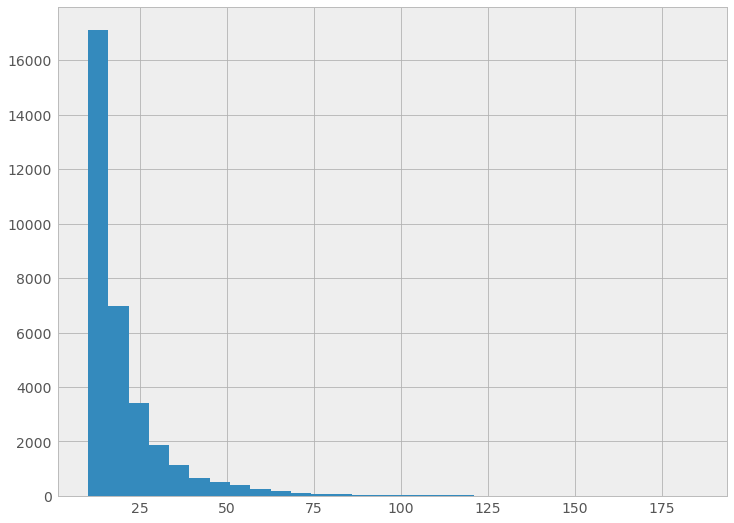

In [41]:
riders_dist_count[riders_dist_count<200].hist(bins=30)

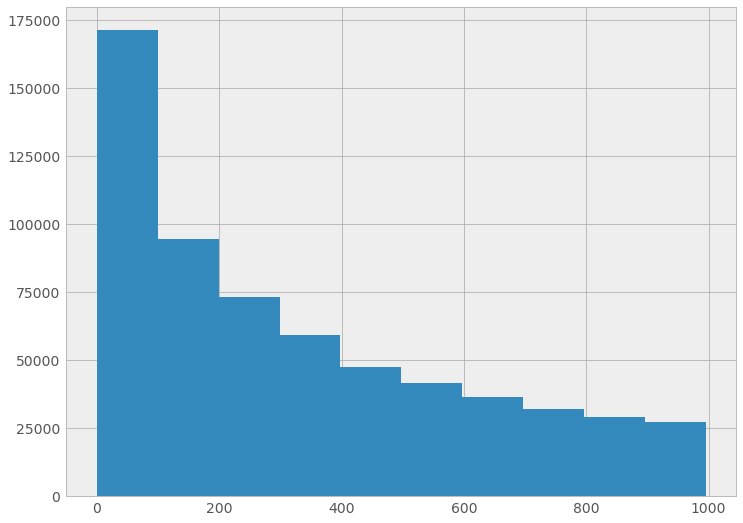

In [107]:
df_orders_drivers.total_loyalty_points[
    df_orders_drivers.total_loyalty_points < 1000
].hist()

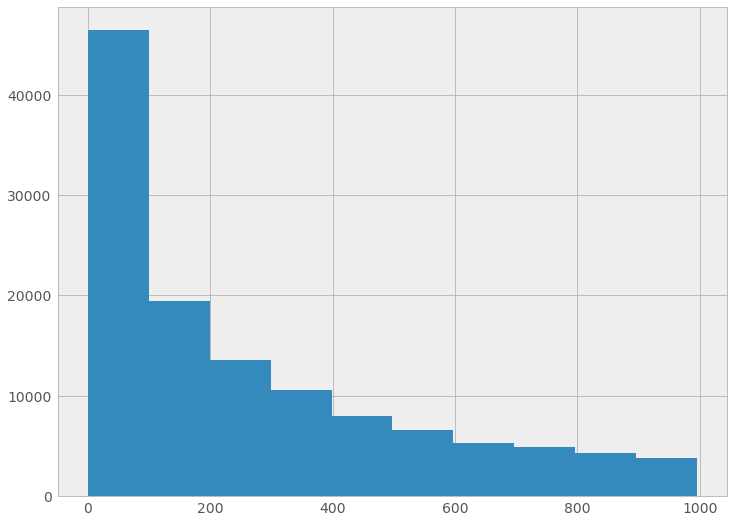

In [106]:
df_orders_drivers[df_orders_drivers.order_status == 'Rejected'].total_loyalty_points[
    df_orders_drivers[df_orders_drivers.order_status == 'Rejected'].total_loyalty_points < 1000
].hist()

In [102]:
df_orders_drivers[df_orders_drivers.order_status == 'Rejected'].head()

,order_gk,order_datetime,driver_gk,order_status,class_type,rider_total_cost,paid_with_prepaid,payment_type,ride_type,m_ride_duration,ride_distance_key,m_driver_wait_time,m_rating,rider_ftp_date_key,rider_main_device_desc,driver_ftp_date_key,driver_device_platform,total_loyalty_points,acquisition_channel_desc,hour,date
3704,72771,2017-09-19 15:50:26.000000,2561,Rejected,Standard,NaN,NaN,Cash,business,NaN,NaN,NaN,NaN,2017-08-28,iPhone,1900-01-01,Unknown,120,NaN,15,2017-09-19 15:50:26
3705,1267725,2017-09-12 18:23:34.000000,2561,Rejected,Standard,0.0,NaN,Credit_card,private,NaN,NaN,NaN,NaN,1900-01-01,iPhone,1900-01-01,Unknown,5,NaN,18,2017-09-12 18:23:34
3706,1202435,2017-09-10 19:39:16.000000,2561,Rejected,Economy,0.0,NaN,Cash,private,NaN,NaN,NaN,NaN,1900-01-01,iPhone,1900-01-01,Unknown,5,NaN,19,2017-09-10 19:39:16
3710,149113,2017-09-24 14:11:47.000000,2561,Rejected,Economy,NaN,NaN,Cash,private,NaN,NaN,NaN,NaN,1900-01-01,iPhone,1900-01-01,Unknown,5,NaN,14,2017-09-24 14:11:47
3711,981596,2017-09-24 14:14:56.000000,2561,Rejected,Economy,NaN,NaN,Cash,private,NaN,NaN,NaN,NaN,1900-01-01,iPhone,1900-01-01,Unknown,5,NaN,14,2017-09-24 14:14:56


In [ ]:
df_

In [24]:
df_orders_drivers.order_status.value_counts()

Completed    793124
Cancelled    286213
Rejected     191428
Name: order_status, dtype: int64

In [41]:
df_orders_drivers['date'] = pd.to_datetime(df_orders_drivers.order_datetime)

In [43]:
df_orders_drivers['hour'] = df_orders_drivers.apply(lambda x: x.date.hour, axis=1)
df_orders_drivers['hour'] = df_orders_drivers.apply(lambda x: x.date.hour, axis=1)

In [84]:
count2, division2 = np.histogram(df_orders_drivers[df_orders_drivers.order_status == 'Rejected'].hour, bins = range(0,25))

In [85]:
count, division = np.histogram(df_orders_drivers.hour, bins=range(0,25))

In [86]:
len(count2)

24

In [87]:
len(count2)

24

In [88]:
count3 = count2/count

<Container object of 24 artists>

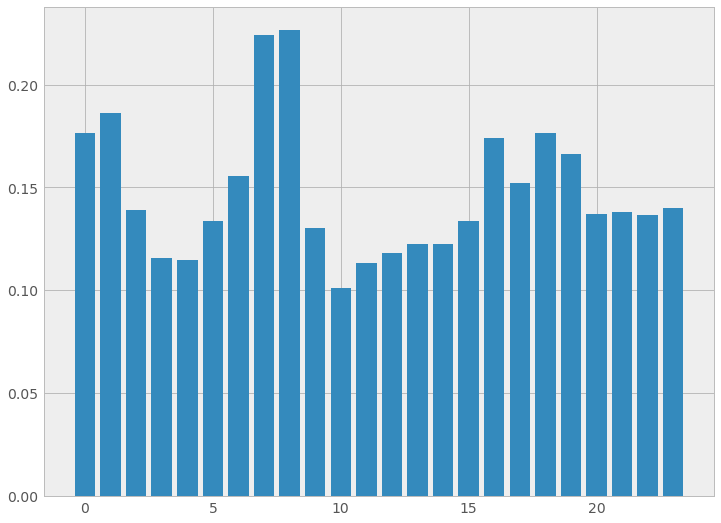

In [92]:
plt.bar(division[:-1], count3)

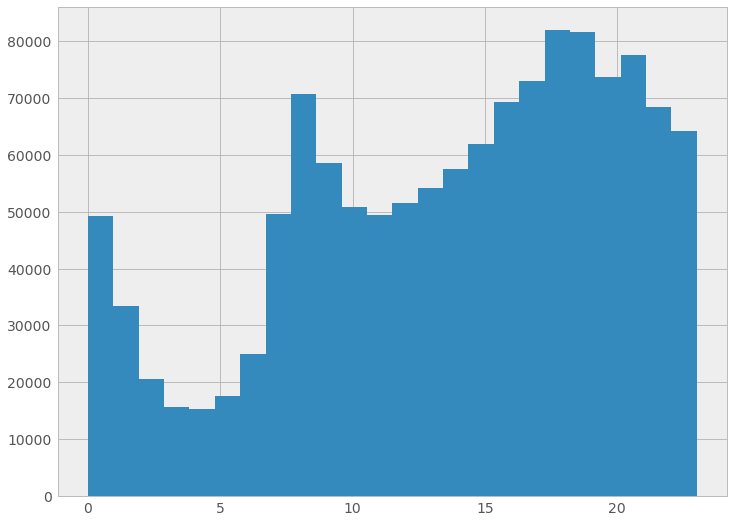

In [55]:
df_orders_drivers.hour.hist(bins=24)

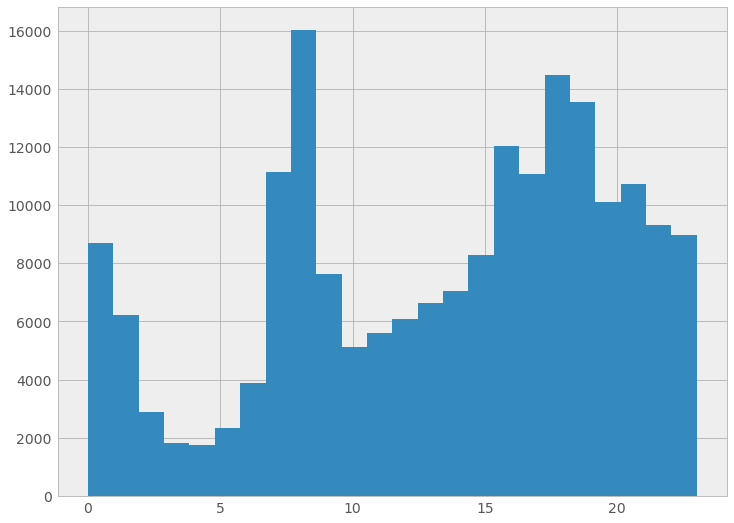

In [47]:
df_orders_drivers[df_orders_drivers.order_status == 'Rejected'].hour.hist(bins=24)

In [28]:
df_orders_riders[df_orders_riders.order_status == 'Rejected'].order_datetime

AttributeError: 'Series' object has no attribute 'hour'

In [118]:
df_orders_drivers = pd.read_csv('./orders_drivers.csv')
df_text_origin = pd.read_csv('./text_origin.csv')
df_text_dest = pd.read_csv('./text_dest.csv')
df_orders_riders = pd.read_csv('./orders_riders.csv')

In [119]:
df_text_origin.head()

,order_gk,hour_key,weekday_key,origin_full_address,origin_latitude,origin_longitude
0,529274,15,3,"Юбилейный проспект, д.74а, Химки",55.894901000000004,37.410573
1,161095,19,0,"МЕГА Теплый Стан, Калужское шоссе 21км, Сосенское",55.604228000000006,37.491983000000005
2,179230,23,6,"метро Станция Аннино, Москва",55.583367,37.596692
3,569188,8,5,"Можайское шоссе, д.6, Москва",55.722531999999994,37.438834
4,335006,17,2,"Аргуновская улица, д.6, к.1, Москва",55.814663,37.621176


In [117]:
df_text_dest.head()

NameError: name 'df_text_dest' is not defined

In [112]:
regions = geojson.loads(open('../hackathon_mckinsey/moscow_regions_geojson.geojson').read())

In [113]:
region_polygons = {(region['properties']['ADMIN_LVL'], region['properties']['NAME']):
                   region['geometry']['coordinates']
                   for region in regions['features']}
region_polygons = {k:v[0][0]for k,v in region_polygons.items() if k[0] in ['8']}

In [116]:
region_paths = {k:path.Path(v) for k,v in region_polygons.items()}

In [133]:
sorted(df_text_origin.origin_latitude.unique())[-1]

'null'

In [121]:
%%time
for k,v in region_paths.items():
    df_text_origin[k[1]] = v.contains_points(df_text_origin[['origin_longitude', 'origin_latitude']])
    print('\r{} done'.format(k[1]), end=' ')

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'